In [2]:
!pip install tensorflow

  Using cached tensorflow-2.13.0rc1-cp310-cp310-macosx_12_0_arm64.whl (2.0 kB)
  Using cached tensorflow_macos-2.13.0rc1-cp310-cp310-macosx_12_0_arm64.whl (189.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:0000:0100:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 2.0 MB/s eta 0:00:0000:0100:01
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.0-py2.py3-none-macosx_11_0_arm64.whl (24.3 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached wrapt-1.15.0-cp310-cp310-macosx_11_0_arm64.whl (36 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached Markdown-3.4.3-py3-none-any.whl (9

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Data Collection & Preprocessing

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("data/train", shuffle=True, 
                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory("data/test", shuffle=True, 
                                                               image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 394 files belonging to 4 classes.


In [16]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

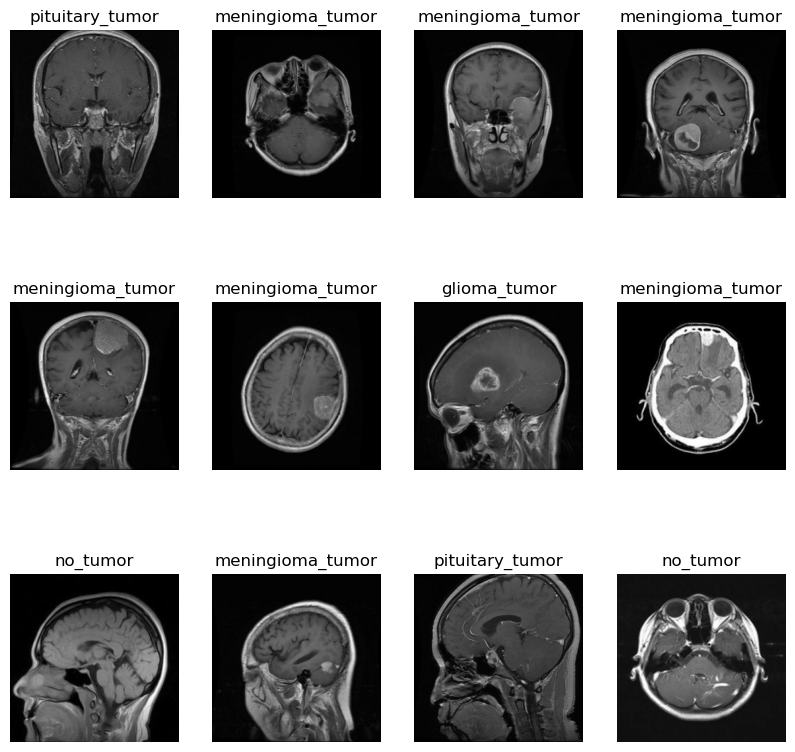

In [26]:
#look at 12 test images in the one batch
plt.figure(figsize=(10,10))
for im, label in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label[i]])

In [30]:
#num of batch in val set
len(val_ds)

13

In [40]:
#function to get train, valid, and test datasets
def get_val_test(val_ds, test_prop):
    val_ds = val_ds.shuffle(10000)
    test_size = int(test_prop*len(val_ds))
    test_ds = val_ds.take(test_size)
    val_ds = val_ds.skip(test_size)
    return val_ds, test_ds

In [41]:
val_ds, test_ds = get_val_test(val_ds, 0.5)

In [42]:
len(test_ds)

6

In [44]:
#optimize datasets for training performance with caching & prefetch 
def optimize_ds():
    global train_ds, val_ds, test_ds
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

optimize_ds()

In [47]:
#preprocessing layers to resize and scale the images, not just in training but also when we're using the model later
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [48]:
#data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Build the model